In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import seaborn as sns

### Load model

In [2]:
from in_silico.model.mlflow_loader import ModelPaths, DataPaths, load_free_viewing_model_from_mlflow

model_paths = ModelPaths(
    checkpoint_uri="mlflow-artifacts:/621818231566971674/2f85fd6f5dda46e280456d3186618e1c/artifacts/6806be20120f307fa684cd4c637ad949_final.pth.tar",
    config_uri="mlflow-artifacts:/621818231566971674/2f85fd6f5dda46e280456d3186618e1c/artifacts/6806be20120f307fa684cd4c637ad949_final_cfg.pth.tar",
)
data_paths = DataPaths(session_dirs=["/mnt/data1/enigma/goliath_10_20_sandbox/37_3843837605846_0_V3A_V4/"])

out = load_free_viewing_model_from_mlflow(
    model_paths,
    data_paths,
    cuda_visible_devices="9",
    mlflow_tracking_uri="https://mlflow.enigmatic.stanford.edu/",
    mlflow_username="mlflow-runner",
    mlflow_password="x3i#U9*73N75",
)

Skipping import of cpp extensions due to incompatible torch version 2.7.0a0+7c8ec84dab.nv25.03 for torchao version 0.16.0             Please see https://github.com/pytorch/ao/issues/2919 for more info


/usr/local/lib/python3.12/dist-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


Dataset 0: 37_3843837605846_0_V3A_V4, length = 215312
Sessions: ['37_3843837605846_0_V3A_V4']
Batches per session: {'37_3843837605846_0_V3A_V4': 26914}
Total batches: 26914
Created FastSessionDataLoader with 1 sessions and 26914 total batches
Dataset 0: 37_3843837605846_0_V3A_V4, length = 22977
Sessions: ['37_3843837605846_0_V3A_V4']
Batches per session: {'37_3843837605846_0_V3A_V4': 2872}
Total batches: 2872
Created FastSessionDataLoader with 1 sessions and 2872 total batches


In [3]:
from in_silico.model.wrapper import ModelWrapper

# out is the tuple returned by load_free_viewing_model_from_mlflow(...)
model, skip_samples, cfg, extra = out   # <-- now cfg exists

# pick skip_samples: prefer the returned value if it exists
# (some codebases return it explicitly, and cfg may or may not have it)
if skip_samples is None:
    skip_samples = cfg.trainer.skip_n_samples

wrapper = ModelWrapper(model, skip_samples=skip_samples)

### Load indices

In [4]:
indices_v3a = np.load('/workdir/analysis_parametric/indices_v3a.npy')

### Create stimulus

In [5]:
from in_silico.stimuli.sparse_noise import SparseNoiseSpec, make_sparse_noise

In [6]:
spec = SparseNoiseSpec(
    num_samples=12,
    dot_offset_samples=1,
    dot_duration_samples=6,
    fps=30.0,
    square_size_px = 100,
    dots_per_frame = 1,
    seed= 61
)

frames, ts, events = make_sparse_noise(spec)

In [7]:
frames.shape

(12, 3, 236, 420)

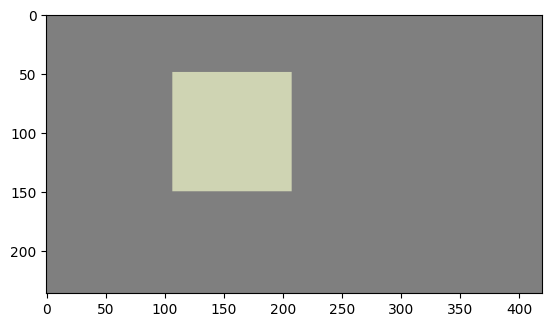

In [10]:
plt.imshow(frames[5].transpose((1,2,0)))

### Predict responses

In [14]:
import numpy as np

def downsample_avg_pool_nchw(x: np.ndarray, factor: int) -> np.ndarray:
    """
    x: (T,C,H,W) or (N,C,H,W) float/uint
    returns: same leading dims, (.., C, H//factor, W//factor)
    """
    if factor == 1:
        return x

    *lead, C, H, W = x.shape
    if H % factor != 0 or W % factor != 0:
        raise ValueError(f"H,W must be divisible by factor. Got H={H}, W={W}, factor={factor}")

    x = x.reshape(*lead, C, H // factor, factor, W // factor, factor)
    return x.mean(axis=(-1, -3))


In [23]:
from __future__ import annotations

from dataclasses import replace
from tqdm.auto import tqdm
import numpy as np

# ---- RGB stats in 0..255 space (your provided values)
_RGB_MEAN_255 = np.array([101.53574522, 93.05977233, 81.9272337], dtype=np.float32)
_RGB_STD_255  = np.array([65.57974361, 63.30442289, 65.71941174], dtype=np.float32)

def normalize_input(x: np.ndarray) -> np.ndarray:
    """
    Normalize video/image using provided RGB mean/std (defined in 0..255 space).

    Accepts:
      - (T,C,H,W) or (C,H,W)
      - values either in [0,1] or [0,255]
    Returns:
      - float32 normalized array, same shape
    """
    x = x.astype(np.float32, copy=False)

    # If looks like [0,1], convert to [0,255]
    if x.max() <= 1.5:
        x = x * 255.0

    if x.ndim == 4:        # (T,C,H,W)
        mean = _RGB_MEAN_255[None, :, None, None]
        std  = _RGB_STD_255[None, :, None, None]
    elif x.ndim == 3:      # (C,H,W)
        mean = _RGB_MEAN_255[:, None, None]
        std  = _RGB_STD_255[:, None, None]
    else:
        raise ValueError(f"normalize_input expected 3D or 4D input, got {x.shape}")

    return ((x - mean) / std).astype(np.float32, copy=False)


def predict_store_raw_stim_and_window_avg(
    wrapper,
    # ---- Model/session key ----
    key: str = "37_3843837605846_0_V3A_V4",
    # ---- Stimulus parameters ----
    num_samples: int = 12,
    dot_offset_samples: int = 3,
    dot_duration_samples: int = 6,
    fps: float = 30.0,
    square_size_px: int = 100,
    dots_per_frame: int = 1,
    base_seed: int = 61,
    # ---- Dataset parameters ----
    N: int = 50,
    batch_size: int = 8,
    # ---- Response window ----
    win_start: int = 2,
    win_dur: int = 6,
    # ---- Downsampling for storage/STA ----
    ds_factor: int = 1,        # e.g. 2 or 4; 1 = no downsample
    # ---- dtype ----
    dtype=np.float32,
):
    """
    Generates N sparse-noise stimuli, predicts responses, stores RAW stimulus frames
    optionally downsampled by ds_factor (avg-pool), baseline-shifts predictions so t0=0,
    and computes mean response in [win_start, win_start+win_dur).

    Assumes you have:
      - SparseNoiseSpec + make_sparse_noise(spec) returning frames (T,C,H,W) in [0,1]
      - downsample_avg_pool_nchw(frames_tchw, ds_factor) -> (T,C,Hds,Wds)
      - wrapper.predict(frames_tchw) expects (T,C,H,W)  ✅ (per your assertion)
    """
    wrapper.key = key

    base_spec = SparseNoiseSpec(
        num_samples=num_samples,
        dot_offset_samples=dot_offset_samples,
        dot_duration_samples=dot_duration_samples,
        fps=fps,
        square_size_px=square_size_px,
        dots_per_frame=dots_per_frame,
        seed=base_seed,
        rgb=True,
    )

    win_end = win_start + win_dur

    frames_batches = []
    pred_batches = []
    avg_batches = []
    seeds = []

    pbar = tqdm(total=N, desc="Predicting + storing RAW stim", unit="stim")

    for start in range(0, N, batch_size):
        b = min(batch_size, N - start)

        frames_list = []
        preds_list = []
        seeds_list = []

        for i in range(b):
            seed_i = base_seed + start + i
            spec_i = replace(base_spec, seed=seed_i)

            # ---- Generate RAW stimulus (full-res) ----
            frames_raw, _, _ = make_sparse_noise(spec_i)  # (T,C,H,W) in [0,1]

            # ---- Downsample for storage/STA (optional) ----
            frames_store = downsample_avg_pool_nchw(
                frames_raw.astype(np.float32, copy=False),
                ds_factor
            )  # (T,C,Hds,Wds)

            # ---- Normalize only for prediction (use full-res frames_raw) ----
            frames_norm = normalize_input(frames_raw)     # (T,C,H,W) normalized float32

            # ---- Predict (NO batch dim; wrapper wants (T,C,H,W)) ----
            pred_ut, info = wrapper.predict(frames_norm)  # (U,T_pred)

            frames_list.append(frames_store.astype(dtype, copy=False))
            preds_list.append(pred_ut.astype(dtype, copy=False))
            seeds_list.append(seed_i)

            pbar.update(1)

        frames_btchw = np.stack(frames_list, axis=0)  # (b,T,C,Hds,Wds)
        pred_but = np.stack(preds_list, axis=0)       # (b,U,T_pred)

        # ---- Baseline shift so first timepoint = 0 ----
        pred_but = pred_but - pred_but[:, :, [0]]

        # ---- Compute window mean ----
        T_pred = pred_but.shape[2]
        w0 = max(0, win_start)
        w1 = min(T_pred, win_end)

        if w1 <= w0:
            avg_bu = np.full((b, pred_but.shape[1]), np.nan, dtype=dtype)
        else:
            avg_bu = pred_but[:, :, w0:w1].mean(axis=2).astype(dtype)

        frames_batches.append(frames_btchw)
        pred_batches.append(pred_but.astype(dtype, copy=False))
        avg_batches.append(avg_bu)
        seeds.extend(seeds_list)

    pbar.close()

    frames_all = np.concatenate(frames_batches, axis=0)   # (N,T,C,Hds,Wds)
    pred_all = np.concatenate(pred_batches, axis=0)       # (N,U,T_pred)
    avg_resp_all = np.concatenate(avg_batches, axis=0)    # (N,U)

    return (
        frames_all,
        pred_all,
        avg_resp_all,
        seeds,
        frames_batches,
        pred_batches,
        avg_batches,
    )

In [187]:
frames_all, pred_all, avg_resp_all, seeds, *_ = predict_store_raw_stim_and_window_avg(
    wrapper,
    key="37_3843837605846_0_V3A_V4",
    num_samples=12,
    dot_offset_samples=3,
    dot_duration_samples=6,
    fps=30.0,
    square_size_px=25,
    dots_per_frame=100,
    base_seed=61,
    N=5000,
    batch_size=10,
    win_start=2,
    win_dur=6,
    ds_factor=4,
)

Predicting + storing RAW stim:   0%|          | 0/5000 [00:00<?, ?stim/s]

In [259]:
def sta_single_stim_frame_weighted_by_resp_window(
    frames_all,            # (N,T,C,H,W) in [0,1] typically
    pred_all,              # (N,U,T_pred)
    t_frame: int = 5,
    skip_frames: int = 0,
    response_offset: int = 0,
    response_duration: int = 6,
    baseline: float = 0.5,
    normalize_weights: bool = True,
    eps: float = 1e-8,
    show_progress: bool = True,
    subtract_stim_mean: bool = True,
    # NEW:
    zscore_normalize: bool = False,  # z-score normalization across neurons
):
    """
    Uses ONLY stimulus frame t_frame from each movie.
    Weight per movie per neuron = mean response over a window on pred timeline
    aligned to that stimulus frame.

    Optionally subtracts the mean stimulus frame across N movies (contrast-space)
    before weighting, which often makes the STA easier to interpret.
    
    If zscore_normalize=True, each neuron's STA is normalized by its spatial std dev
    to make STAs comparable across neurons.

    Returns:
      sta:   (U,C,H,W) float32
      denom: (U,) float32  (sum of weights if normalize_weights else also sum)
      stim_mean_chw: (C,H,W) float32  (returned for visualization / debugging)
    """
    N, T, C, H, W = frames_all.shape
    N2, U, T_pred = pred_all.shape
    assert N == N2
    assert 0 <= t_frame < T

    # Stimulus frame -> contrast around baseline
    frame_nchw = frames_all[:, t_frame].astype(np.float32) - float(baseline)  # (N,C,H,W)

    # Mean-subtract stimulus ensemble (optional)
    stim_mean_chw = frame_nchw.mean(axis=0)  # (C,H,W)
    if subtract_stim_mean:
        frame_nchw = frame_nchw - stim_mean_chw[None, :, :, :]

    # Map stim frame index -> pred time index
    t_pred0 = t_frame - int(skip_frames)

    # Response window indices on pred timeline
    w0 = t_pred0 + int(response_offset)
    w1 = w0 + int(response_duration)

    # Clip to valid range
    w0c = max(0, w0)
    w1c = min(int(T_pred), w1)
    if w1c <= w0c:
        return (
            np.zeros((U, C, H, W), dtype=np.float32),
            np.zeros((U,), dtype=np.float32),
            stim_mean_chw.astype(np.float32),
        )

    # Weights: mean response in window, per (N,U)
    weights_nu = pred_all[:, :, w0c:w1c].mean(axis=2).astype(np.float32)  # (N,U)

    sta = np.zeros((U, C, H, W), dtype=np.float32)
    denom = np.zeros((U,), dtype=np.float32)

    iterator = range(U)
    if show_progress:
        iterator = tqdm(iterator, desc="Computing STA (per neuron)", unit="neuron")

    for u in iterator:
        w_n = weights_nu[:, u]  # (N,)
        sta_num = np.einsum("n,nchw->chw", w_n, frame_nchw).astype(np.float32)

        d = float(w_n.sum())
        denom[u] = d
        if normalize_weights:
            sta[u] = sta_num / (d + eps)
        else:
            sta[u] = sta_num

    # Z-score normalization (optional, after weight normalization)
    if zscore_normalize:
        # Compute std dev per neuron across all spatial/channel dims
        sta_flat = sta.reshape(U, -1)  # (U, C*H*W)
        std_per_neuron = sta_flat.std(axis=1, keepdims=True)  # (U, 1)
        std_per_neuron = std_per_neuron.reshape(U, 1, 1, 1)  # (U, 1, 1, 1)
        sta = sta / (std_per_neuron + eps)

    return sta, denom, stim_mean_chw.astype(np.float32)

def sta_to_rgb(
    sta_chw: np.ndarray,        # (3,H,W) or (C,H,W)
    mode: str = "robust",       # "robust" (percentile) or "maxabs"
    p: float = 99.0,            # percentile for robust scaling
    gamma: float = 1.0,         # optional gamma for display
    center: float = 0.5,        # where 0 maps to in display space
    clip: bool = True,
    eps: float = 1e-8,
) -> np.ndarray:
    """
    Convert STA (which is signed, contrast-like) into a displayable RGB image in [0,1].

    Mapping:
      - Signed STA -> scaled to [-1,1] (robustly)
      - Then shift to [0,1] with center (default 0.5):  disp = center + 0.5 * scaled
      - Optional gamma correction

    Returns:
      rgb_hwc: (H,W,3) float32 in [0,1]
    """
    x = sta_chw.astype(np.float32, copy=False)

    if x.ndim != 3:
        raise ValueError(f"sta_to_rgb expects (C,H,W), got {x.shape}")

    # If single-channel, replicate to RGB for display
    if x.shape[0] == 1:
        x = np.repeat(x, 3, axis=0)
    elif x.shape[0] != 3:
        # if more channels, take first 3 (or you can choose a projection)
        x = x[:3]

    if mode == "robust":
        # robust scale using percentile of absolute values across all pixels/channels
        s = np.percentile(np.abs(x), p)
        s = float(max(s, eps))
        x_scaled = x / s
    elif mode == "maxabs":
        s = float(np.max(np.abs(x)))
        s = float(max(s, eps))
        x_scaled = x / s
    else:
        raise ValueError(f"Unknown mode={mode}. Use 'robust' or 'maxabs'.")

    # clamp to [-1,1] then map to [0,1]
    x_scaled = np.clip(x_scaled, -1.0, 1.0)
    disp = float(center) + 0.5 * x_scaled  # [-1,1] -> [0,1] around center

    if gamma != 1.0:
        disp = np.clip(disp, 0.0, 1.0)
        disp = disp ** (1.0 / float(gamma))

    if clip:
        disp = np.clip(disp, 0.0, 1.0)

    # (C,H,W) -> (H,W,C)
    return np.transpose(disp, (1, 2, 0)).astype(np.float32, copy=False)

In [270]:
# With z-score normalization
sta_normalized, denom, stim_mean = sta_single_stim_frame_weighted_by_resp_window(
    frames_all, pred_all, t_frame=5, zscore_normalize=True
)

Computing STA (per neuron):   0%|          | 0/653 [00:00<?, ?neuron/s]

In [635]:
# Visualize neuron u
idx = np.random.choice(indices_v3a)
rgb = sta_to_rgb(sta_normalized[idx], mode="robust", p=99.5, gamma=1.0)  # (H,W,3) in [0,1]

52


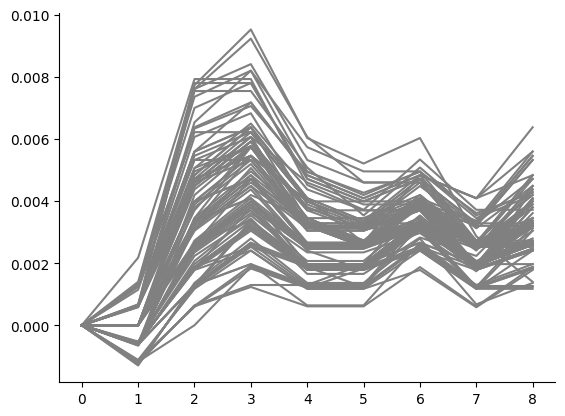

In [636]:
plt.plot(pred_all[np.linspace(0, 4999, 100).astype(int),idx,:].T, color = 'gray')
sns.despine()
print(idx)

(-0.5, 104.5, 58.5, -0.5)

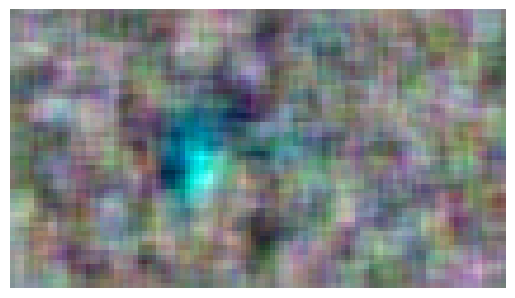

In [637]:
plt.imshow(rgb)
plt.axis("off")

In [610]:
frames_all.shape

(5000, 12, 3, 59, 105)

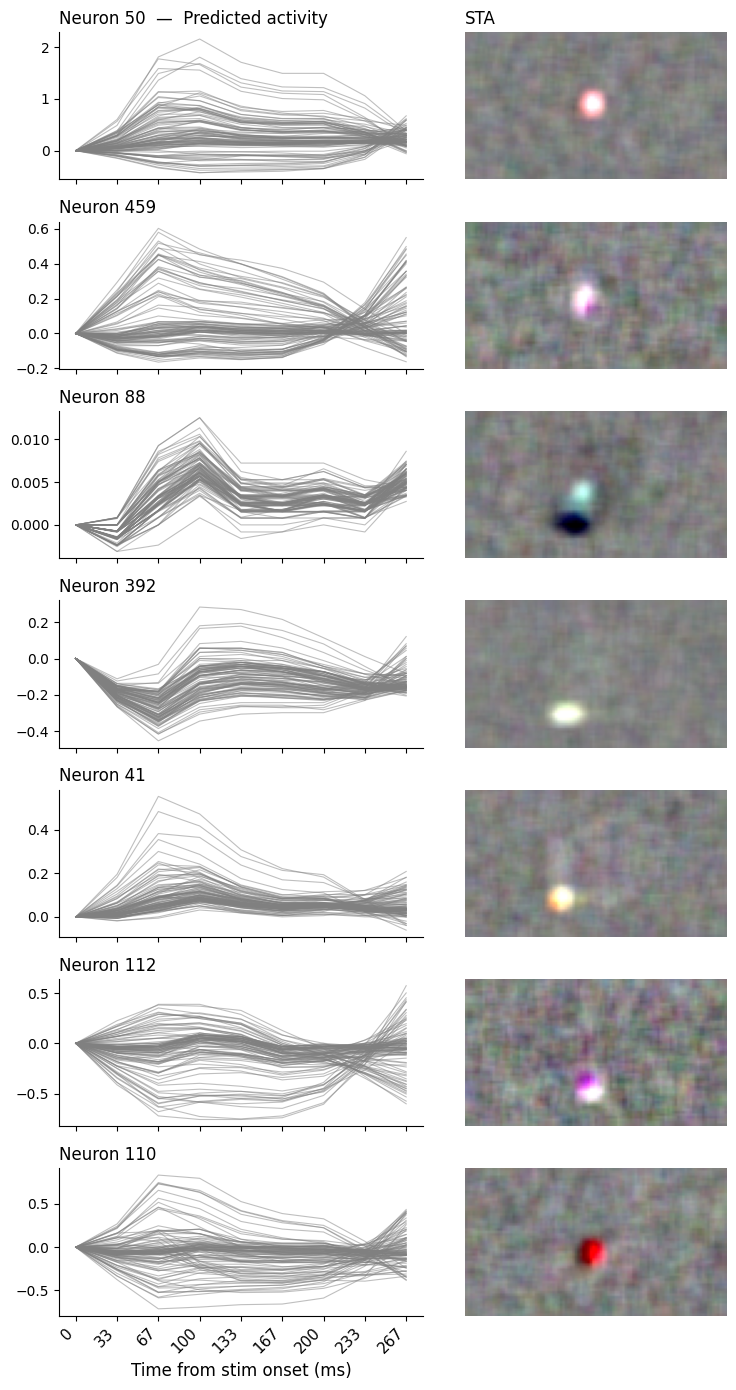

In [651]:
n_neurons = 7
idxs = [50 , 459, 88, 392, 41, 112, 110]#np.random.choice(indices_v3a, size=n_neurons, replace=False)

fig, axes = plt.subplots(n_neurons, 2, figsize=(8, n_neurons * 2),
                         gridspec_kw={"width_ratios": [1, 1]})

sample_ids = np.linspace(0, pred_all.shape[0] - 1, 100).astype(int)

for row, idx in enumerate(idxs):
    # Left: predicted activity traces
    ax_trace = axes[row, 0]
    ax_trace.plot(pred_all[sample_ids, idx, :].T, color="gray", alpha=0.5, lw=0.8)
    sns.despine(ax=ax_trace)
    ax_trace.set_title(f"Neuron {idx}", fontsize=12, loc="left")
    if row == 0:
        ax_trace.set_title(f"Neuron {idx}  —  Predicted activity", fontsize=12, loc="left")

    n_timepoints = pred_all.shape[2]
    times_ms = np.arange(n_timepoints) * (1000 / 30)
    ax_trace.set_xticks(np.arange(n_timepoints))
    ax_trace.set_xticklabels([f"{t:.0f}" for t in times_ms], fontsize=11, rotation=45, ha="right")
    if row == n_neurons - 1:
        ax_trace.set_xlabel("Time from stim onset (ms)", fontsize=12)
    else:
        ax_trace.set_xticklabels([])

    # Right: STA
    ax_sta = axes[row, 1]
    rgb = sta_to_rgb(sta_normalized[idx], mode="robust", p=99.5, gamma=1.0)
    ax_sta.imshow(rgb)
    ax_sta.axis("off")
    if row == 0:
        ax_sta.set_title("STA", fontsize=12, loc="left")

plt.tight_layout()

plt.savefig('Dotmap_RFs.png', dpi = 300)

In [ ]:
50 , 459, 88, 392, 41, 112, 110